# maximum intensity projection visualization at full-resolution using dask

In [25]:
from coiled import Cluster

cluster = Cluster(n_workers=[4,20])
client = cluster.get_client()

╭─────────────────────────────── Coiled Cluster ───────────────────────────────╮
│            ]8;id=820633;https://cloud.coiled.io/clusters/627700?account=akhanf\https://cloud.coiled.io/clusters/627700?account=akhanf]8;;\            │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────── Overview ──────────────╮╭─────────── Configuration ────────────╮
│                                      ││                                      │
│ Name: akhanf-647daeb2                ││ Region: us-east1                     │
│                                      ││                                      │
│ Scheduler Status: started            ││ Scheduler: e2-standard-4             │
│                                      ││                                      │
│ Dashboard:                           ││ Workers:   e2-standard-4 (4)         │
│ ]8;id=577913;https://cluster-kwmqz.dask.host?token=YlL3EASXW0dSlWIG\https://cluster-kwmqz.dask.host?toke]8;;\ ││                                      │
│ ]8;id=577913;https://cluster-kwmqz.dask.host?token=YlL3EASXW0dSlWIG\n=YlL3EASXW0dSlWIG]8;;\                   ││ Workers Requested: 4                 │
│                                      ││                                      │
╰──────────────────────────────────────╯╰──────────────────────────────────────╯
╭───────────────────────── (2024/10/20 18:44:26 EDT) ──────────────────────────╮
│                                                                              │
│                              All workers ready.                              │
│                                                                              │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯

2024-10-20 18:44:32,750 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=4 maximum=20
2024-10-20 18:59:17,751 - distributed.deploy.adaptive - INFO - Adaptive scaling stopped: minimum=4 maximum=20. Reason: cluster-not-running


In [26]:
in_zarr='gcs://khanlab-lightsheet/data/mouse_appmaptapoe/bids_oldBlaze/sub-o21/micr/sub-o21_sample-brain_acq-blaze_SPIM.ome.zarr'

In [27]:
import matplotlib.pyplot as plt
from snakebids import generate_inputs
import dask.array as da
#from dask.diagnostics import ProgressBar

#in_zarr = '/cifs/prado/Kelly/data/lightsheet/bids/test_bids/sub-mouse1/micr/sub-mouse1_sample-brain_acq-4x_spim.ome.zarr.zip'


In [28]:
in_zarr

'gcs://khanlab-lightsheet/data/mouse_appmaptapoe/bids_oldBlaze/sub-o21/micr/sub-o21_sample-brain_acq-blaze_SPIM.ome.zarr'

In [30]:

#get channel 0
darr = da.from_zarr(in_zarr,component='1')[0].rechunk((1834,128,128))
darr

dask.array<rechunk-p2p, shape=(1834, 5979, 5012), dtype=uint16, chunksize=(1834, 128, 128), chunktype=numpy.ndarray>

In [31]:
darr_mip = da.max(darr,axis=0)
darr_mip

dask.array<max-aggregate, shape=(5979, 5012), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

In [32]:
arr_mip = darr_mip.compute()

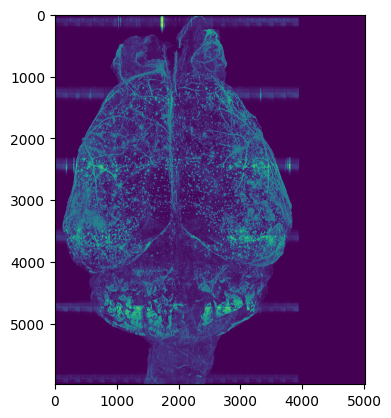

In [33]:
plt.imshow(arr_mip)

In [39]:
import gcsfs
import skimage.io

# Initialize a Google Cloud Storage File System
gcs = gcsfs.GCSFileSystem()

# Path to the GCS bucket and object
gcs_uri = 'gcs://khanlab-lightsheet/data/temp/mip_level1.png'


# Write the image to GCS
with gcs.open(gcs_uri, 'wb') as f:
    skimage.io.imsave(f, arr_mip, plugin='imageio',format='png')


In [ ]:
z=500
darr_slice=darr[z,:,:].squeeze()
skimage.io.imsave(f'z-{z}.tif',darr_slice)

# MIP after rotating in 3D - full example

In [ ]:
from dask_image.ndinterp import affine_transform
from scipy.spatial.transform import Rotation as R
import numpy as np
from scipy.linalg  import inv


def get_rotation_on_center(shape, degrees, axis_name):
        
    r0 = np.eye(4) 
    r0[0,3] = -shape[0]/2
    r0[1,3] = -shape[1]/2
    r0[2,3] = -shape[2]/2
    
    r1 = np.eye(4)
    r1[:3,:3]=R.from_euler(axis_name, degrees, degrees=True).as_matrix()

    #to get rotation around center of image: move origin, rotate, move origin back 
    return inv(r0) @ r1 @ r0

In [ ]:
from pathlib import Path
import zarr
from tqdm import tqdm

subject='mouse1'
acq='4x'
level=4
mip_axis=0 
rot_axis='y'
channel=0
angle_increment=5
z_padding=0.4 #to avoid going out of fov with rotation

in_zarr_pattern = '/cifs/prado/Kelly/data/lightsheet/bids/test_bids/sub-{subject}/micr/sub-{subject}_sample-brain_acq-{acq}_spim.ome.zarr.zip'
in_zarr = in_zarr_pattern.format(subject=subject, acq=acq)

In [ ]:
z_in = zarr.open(in_zarr)
attrs = z_in['/'].attrs.asdict()

#get voxel dimensions for the given level
coord_transforms = attrs['multiscales'][0]['datasets'][level]['coordinateTransformations']
coord_transforms
zscale=coord_transforms[0]['scale'][-3] 
xyscale=coord_transforms[0]['scale'][-2]

#zfactor is how much thicker (greater than 1) /thinner (less than 1) Z is than x and y dims
# ie we need to rescale z dim by this factor to get isotropic volume 
zfactor = zscale/xyscale
zfactor

zstep = int(np.round(1/zfactor))
zstep

In [ ]:
darr_ds = da.from_zarr(in_zarr,component=f'/{level}')[channel][::zstep,:,:]
darr_pad = da.zeros((int(darr_ds.shape[0]*z_padding),darr_ds.shape[1],darr_ds.shape[2]),dtype='uint16')
darr_ds = da.concatenate([darr_pad,darr_ds,darr_pad],axis=0)
                    
out_dir=Path(f'sub-{subject}_acq-{acq}_channel-{channel}_level-{level}_rotate-{rot_axis}_axis-{mip_axis}_MIP')

#make out dir
out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
#generate mips while rotating to make animation

for angle in tqdm(range(0,360,angle_increment)):
    with ProgressBar():
        darr_mip=affine_transform(darr_ds,get_rotation_on_center(darr_ds.shape,angle,rot_axis)).max(axis=mip_axis)
        out_file = out_dir / f'MIP_rotate-{angle:03d}.tif' 
        skimage.io.imsave(out_file,darr_mip)